Saved synthetic auth logs to ../data/processed/auth_logs.csv
Saved risk model to ../models/auth_risk_model.pkl
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00         2

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



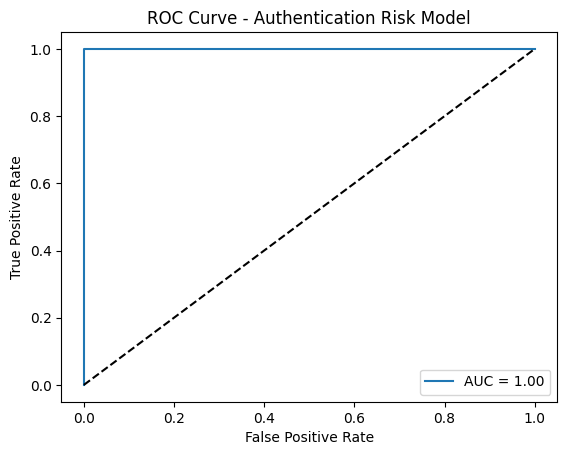

In [1]:
# 05-auth-risk-model.ipynb
# Synthetic Authentication Log Generation & Risk Modeling

"""
## 05 - Authentication Risk Modeling

This notebook:
1. Generates synthetic authentication login records (normal and anomalous).
2. Injects anomalies: geolocation shifts, odd login hours, unknown devices.
3. Creates features for risk analysis (distance, hour, device).
4. Trains a LogisticRegression model to classify anomalies.
5. Evaluates performance and visualizes ROC.
"""

#%%
# 1. Imports and Setup
import os
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

# File paths
LOG_CSV = os.path.join('..', 'data', 'processed', 'auth_logs.csv')
RISK_MODEL_PATH = os.path.join('..', 'models', 'auth_risk_model.pkl')

#%%
# 2. Generate Synthetic Logs
users = {
    'alice': (40.7128, -74.0060),  # NYC
    'bob': (34.0522, -118.2437),   # LA
}
devices = ['Laptop', 'Phone', 'Tablet']

records = []
for day in range(30):
    for user, (lat, lon) in users.items():
        for _ in range(2):
            time = datetime.now() - timedelta(days=day)
            loc = (lat + random.uniform(-0.1,0.1), lon + random.uniform(-0.1,0.1))
            hour = random.randint(7, 20)
            device = random.choice(devices)
            records.append({
                'user': user, 'time': time.replace(hour=hour),
                'lat': loc[0], 'lon': loc[1], 'device': device,
                'anomaly': 0
            })

# Inject anomalies
records.append({  # far away
    'user': 'alice', 'time': datetime.now(),
    'lat': 48.8566, 'lon': 2.3522,  # Paris
    'device': 'Unknown', 'anomaly': 1
})
records.append({  # midnight login
    'user': 'bob', 'time': datetime.now().replace(hour=2),
    'lat': 34.05, 'lon': -118.24, 'device': 'Laptop', 'anomaly': 1
})

logs_df = pd.DataFrame(records)
logs_df.to_csv(LOG_CSV, index=False)
print("Saved synthetic auth logs to", LOG_CSV)

#%%
# 3. Feature Engineering for Risk
user_home = {u: (lat, lon) for u, (lat, lon) in users.items()}

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

logs_df['login_hour'] = pd.to_datetime(logs_df['time']).dt.hour
logs_df['distance_km'] = logs_df.apply(lambda row: 
    haversine(row['lat'], row['lon'], *user_home[row['user']]), axis=1)
logs_df['new_device'] = logs_df['device'].apply(lambda d: 1 if d == 'Unknown' else 0)

#%%
# 4. Train Risk Model
features = ['distance_km', 'login_hour', 'new_device']
X = logs_df[features]
y = logs_df['anomaly']
clf = LogisticRegression()
clf.fit(X, y)

# Save model
import joblib
joblib.dump(clf, RISK_MODEL_PATH)
print("Saved risk model to", RISK_MODEL_PATH)

#%%
# 5. Evaluate
y_prob = clf.predict_proba(X)[:,1]
y_pred = clf.predict(X)
print(classification_report(y, y_pred))
roc_auc = roc_auc_score(y, y_prob)

fpr, tpr, _ = roc_curve(y, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Authentication Risk Model')
plt.legend()
plt.show()
